In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import model.Spectra_MAE as spectra_mae


def show_spectra(x, y, title=''):
    plt.figure(figsize=(8, 5), dpi=100)
    plt.plot(x, y)
    plt.ylim((0, 1))
    # plt.savefig('./restruction_pathogenic_figure.jpeg')
    plt.show()

def show_masked(x, y, title=''):
    plt.figure(figsize=(8, 5), dpi=100)
    ax = plt.gca()
    ax.spines['bottom'].set_position(("data", 0))       # 调整x轴
    ax.spines['top'].set_visible(False)             # 去掉上侧边框
    ax.spines['right'].set_visible(False)           # 去掉右侧边框
    plt.ylim((-0.2, 1))
    for i in range(0, 1000, 100):               # 1000
        plt.plot(x[i:i+100], y[i:i+100], color='#1f77b4',)
    # plt.savefig('./masked_pathogenic_figure.jpeg')

def prepare_model(chkpt_dir, arch='spectraMAE_base_patch100'):
    model = getattr(spectra_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cuda:0')
    msg = model.load_state_dict(checkpoint)
    print(msg)
    return model

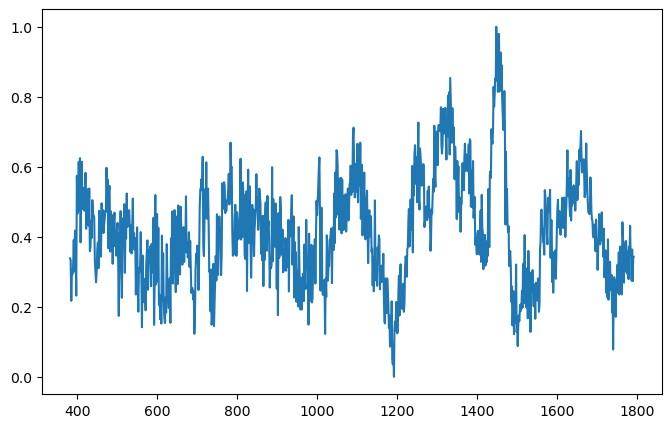

In [2]:
# Pathogenic
import os

pathogenic_path = '/ftp_file/RenPengju/Raman_code/RamanSpectra/DataSet/Bacteria'
wave_num = np.load(os.path.join(pathogenic_path, 'wavenumbers.npy'))
# wave_num = np.arange(1000)
y = np.load(os.path.join(pathogenic_path, 'X_finetune.npy'))
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(wave_num, y[1])
plt.show()

In [3]:
chkpt_dir = 'param/30_final.pth'
model_mae = prepare_model(chkpt_dir=chkpt_dir)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [4]:
spectra_tensor = torch.from_numpy(y[1]).view(1, -1).float()
spectra_tensor = spectra_tensor.view(1, 1, 1000)
loss, pred, mask = model_mae(spectra_tensor, mask_ratio=0.7)
pred = model_mae.unpatchify(pred)
pred = pred.detach().numpy()
pred = pred.reshape(1000, )

mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, 100)
mask = model_mae.unpatchify(mask)
mask = mask.detach().numpy().reshape(1000, )

im_mask = y[1].copy()
for i in range(0, 1000, 100):
    if mask[i] == 1:
        im_mask[i: i+100] = [(j * (1 - mask[i // 100]) - 0.1 )for j in y[1][i:i+100]]

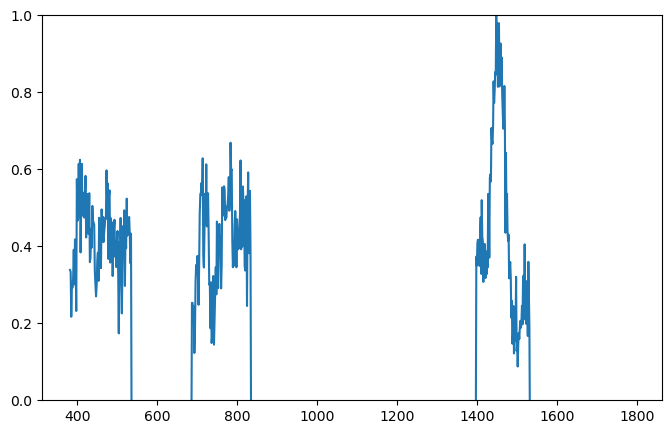

In [5]:
show_spectra(wave_num, im_mask, 'reconstruction')

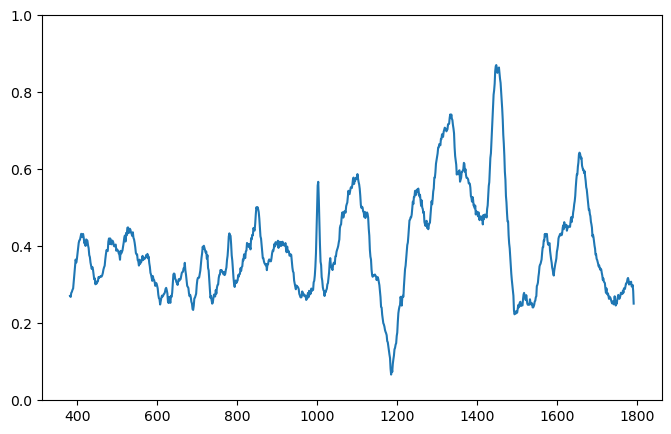

In [6]:
show_spectra(wave_num, pred, 'reconstruction')

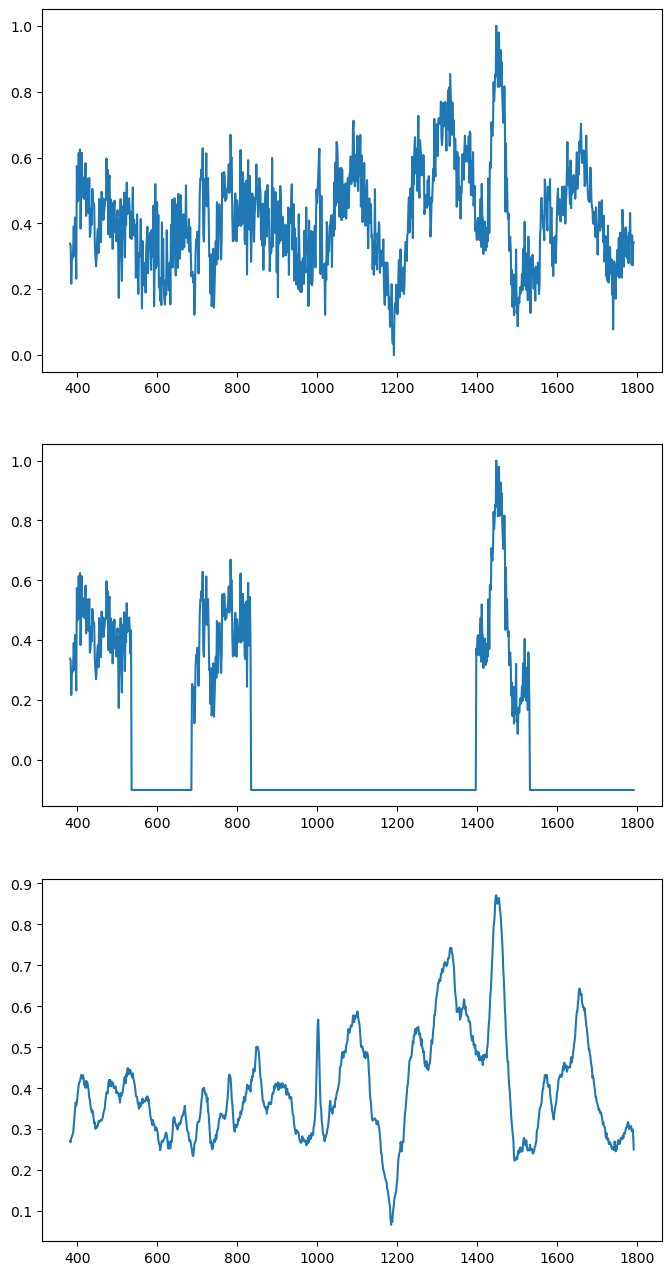

In [7]:
plt.figure(figsize=(8, 16), dpi=100)

plt.subplot(3, 1, 1)
plt.plot(wave_num, y[1])

plt.subplot(3, 1, 2)
plt.plot(wave_num, im_mask)

plt.subplot(3, 1, 3)
plt.plot(wave_num, pred)